### Example getting T and EM from GOES/XRS15 data

At the moment just for GOES15 and using CHIANTI with coronal abundances, using python port of sswidl [goes_tem_calc.pro](https://hesperia.gsfc.nasa.gov/ssw/gen/idl/synoptic/goes/goes_tem_calc.pro).

* 24-10-21   IGH
* 
---

In [1]:
import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import goesxrs_temp as gtem

from sunpy import timeseries as ts
from sunpy.net import attrs as a

In [2]:
# # Reimports for when developing the module/functions
# import importlib
# importlib.reload(gtem)

In [3]:
plt.rcParams.update({'font.size': 18,'font.family':"sans-serif",\
                         'font.sans-serif':"Arial",'mathtext.default':"regular"})

In [4]:
# For testing get the T response ratio:
resprat, resptmk = gtem.get_resprat()

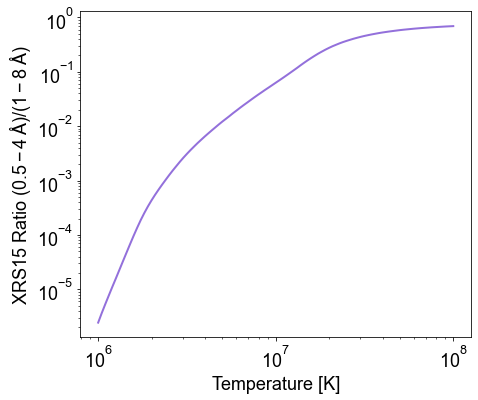

In [5]:
# Plot it to see what it is like:
fig,ax = plt.subplots(figsize=(7, 6))
plt.plot(1e6*resptmk,resprat,marker=None,color='mediumpurple',lw=2)
ax.set_ylabel("XRS15 Ratio $(0.5-4\;\AA)$/$(1-8\;\AA)$")
ax.set_xlabel("Temperature [K]")
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

In [6]:
# For testing get the T responses:
resps, resptmk = gtem.get_resps()

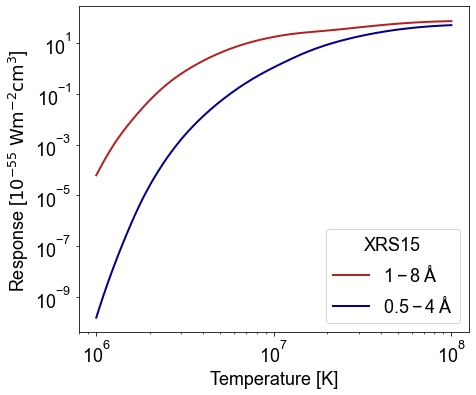

In [7]:
# Plot it to see what it is like:
fig,ax = plt.subplots(figsize=(7, 6))
plt.plot(1e6*resptmk,resps[:,0],marker=None,color='firebrick',lw=2,label='$1-8\;\AA$')
plt.plot(1e6*resptmk,resps[:,1],marker=None,color='darkblue',lw=2,label='$0.5-4\;\AA$')

ax.set_ylabel("Response [$\mathrm{10^{-55}\;Wm^{-2}cm^{3}}$]")
ax.set_xlabel("Temperature [K]")
ax.set_xscale("log")
ax.set_yscale("log")
plt.legend(title='XRS15')
plt.show()

In [8]:
# # Some testing that it
# # works for single value
# tmk, em=gtem.get_tem(1e-8/0.04,1e-8)
# print(tmk,em)

# # works for array of values including bad ones
# fl=[1e-8/0.04,2e-8/0.04,-1,0]
# fs=[1e-8,1e-8,1e-8,1e-8]
# tmks,ems=gtem.get_tem(fl,fs)
# print(tmks,ems)

---
##### Now getting T, EM from XRS data

In [9]:
#  OK lets now try with real data
# Assumes have downloaded data via https://github.com/ianan/xrs_example/blob/main/xrs15_example.ipynb
# Load data into timeseries
outdir='/Users/iain/sunpy/data/'
fg15=glob.glob(outdir+'*g15*20101105*.nc')
g15 = ts.TimeSeries(fg15, concatenate=True)
# Then truncate to time range interested in
trange=a.Time("2010-11-05 12:00","2010-11-05 17:00")
tg15=g15.truncate(trange.start.iso,trange.end.iso)
# Extract out the time index and data channels
tg_tims=tg15.index
tg_x05=tg15.quantity("xrsa").value
tg_x18=tg15.quantity("xrsb").value

In [10]:
# Also need to work out an average background level in each GOES channel 
tbck=a.Time("2010-11-05 13:06:19","2010-11-05 13:07:30")
tbckg15=g15.truncate(tbck.start.iso,tbck.end.iso)
# Work out mean for each channel
# Need to be careful that no 0, negs or NaNs in there.....
bck05=np.mean(tbckg15.quantity("xrsa").value)
bck18=np.mean(tbckg15.quantity("xrsb").value)
print(bck05,bck18)

1.0988658e-08 5.4663786e-07


In [11]:
# Work out values using original, no backsub
tmk, em=gtem.get_tem(tg_x18,tg_x05)
# And with the background subtraction
tmk_bs,em_bs=gtem.get_tem(tg_x18-bck18,tg_x05-bck05)

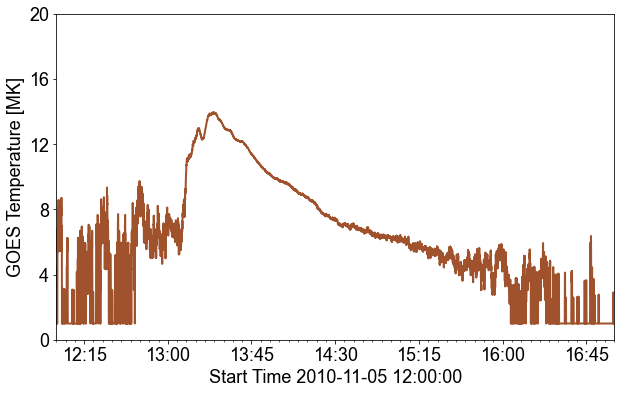

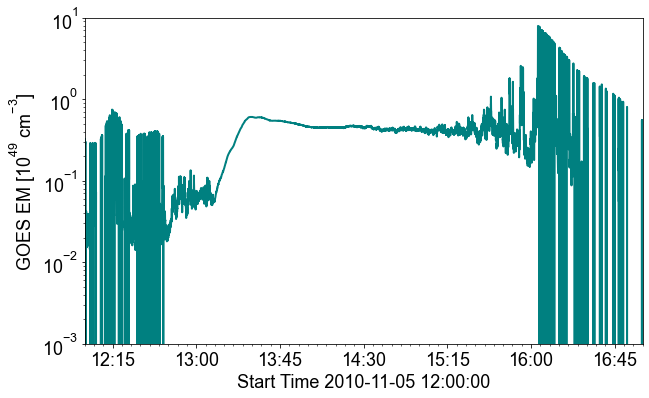

In [12]:
# Plot just the non-background subtracted for whole time range
fig,ax = plt.subplots(figsize=(10, 6))
plt.plot(tg_tims,tmk,marker=None,color='sienna',lw=2,label='No Sub')
# plt.plot(tg_tims,tmk_bs,marker=None,color='sienna',lw=2,ls='--',label='Back Sub')
ax.set_ylabel("GOES Temperature [MK]")
ax.set_xlabel("Start Time "+trange.start.iso[:-4])
ax.set_ylim([0,20])
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
ax.set_xlim([trange.start.datetime,trange.end.datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=45)
minorx= matplotlib.dates.MinuteLocator(interval=5)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
# plt.legend()
plt.show()


fig,ax = plt.subplots(figsize=(10, 6))
# plt.plot(tg_tims[tmk > 4],em[tmk > 4]*1e-49,marker=None,color='teal',lw=2,label='No Sub')
plt.plot(tg_tims,em*1e-49,marker=None,color='teal',lw=2,label='No Sub')
ax.set_ylabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax.set_xlabel("Start Time "+trange.start.iso[:-4])
ax.set_ylim([1e-3,1e1])
ax.set_yscale("log")
ax.set_xlim([trange.start.datetime,trange.end.datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=45)
minorx= matplotlib.dates.MinuteLocator(interval=5)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
# plt.legend()
plt.show()


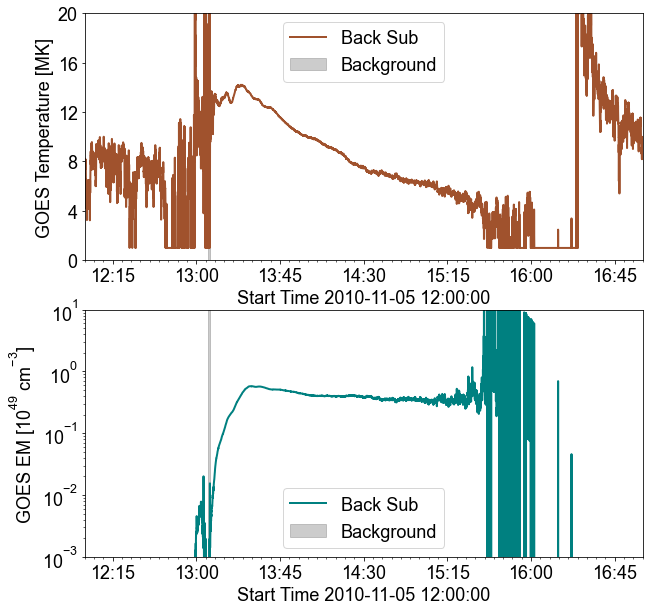

In [13]:
# Plot background subtracted for whole time range
fig= plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(2, 1, 1)
plt.plot(tg_tims,tmk_bs,marker=None,color='sienna',lw=2,label='Back Sub')
ax1.set_ylabel("GOES Temperature [MK]")
ax1.set_xlabel("Start Time "+trange.start.iso[:-4])
ax1.set_ylim([0,20])
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_xlim([trange.start.datetime,trange.end.datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=45)
minorx= matplotlib.dates.MinuteLocator(interval=5)
ax1.xaxis.set_major_locator(majorx)
ax1.xaxis.set_minor_locator(minorx)
ax1.xaxis.set_major_formatter(myFmt)
ax1.axvspan(tbck.start.datetime,tbck.end.datetime,color='grey',alpha=0.4, label='Background')
plt.legend()

ax2 = fig.add_subplot(2, 1, 2)
plt.plot(tg_tims,em_bs*1e-49,marker=None,color='teal',lw=2,label='Back Sub')
ax2.set_ylabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax2.set_xlabel("Start Time "+trange.start.iso[:-4])
ax2.set_ylim([1e-3,1e1])
ax2.set_yscale("log")
ax2.set_xlim([trange.start.datetime,trange.end.datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=45)
minorx= matplotlib.dates.MinuteLocator(interval=5)
ax2.xaxis.set_major_locator(majorx)
ax2.xaxis.set_minor_locator(minorx)
ax2.xaxis.set_major_formatter(myFmt)
ax2.axvspan(tbck.start.datetime,tbck.end.datetime,color='grey',alpha=0.4, label='Background')
plt.legend()
plt.show()


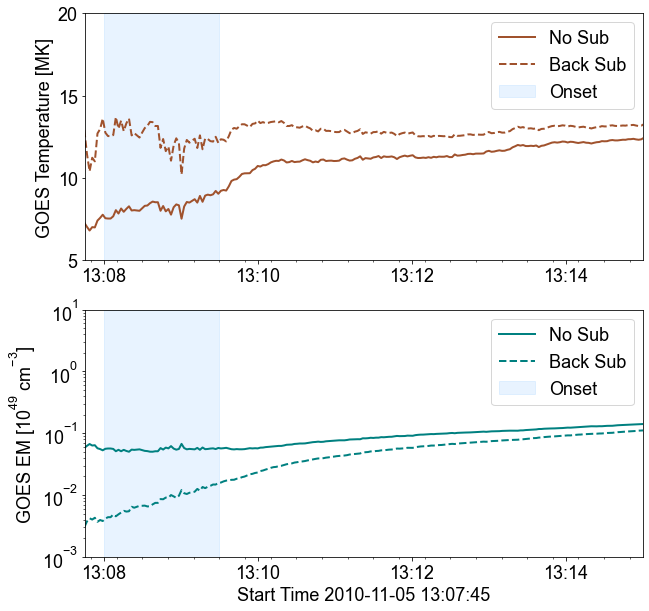

In [14]:
# Just plot range close to Fig 1 in Hudson et al. 2021 paper so can consider 
tr2=a.Time("2010-11-05 13:07:45","2010-11-05 13:15:00")
tho=a.Time("2010-11-05 13:08:00","2010-11-05 13:09:30")

fig= plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(2, 1, 1)
plt.plot(tg_tims,tmk,marker=None,color='sienna',lw=2,label='No Sub')
plt.plot(tg_tims,tmk_bs,marker=None,color='sienna',lw=2,ls='--',label='Back Sub')
ax1.set_ylabel("GOES Temperature [MK]")
# ax1.set_xlabel("Start Time "+tr2.start.iso[:-4])
ax1.set_ylim([5,20])
ax1.yaxis.set_major_locator(plt.MaxNLocator(3))
ax1.set_xlim([tr2.start.datetime,tr2.end.datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=2)
minorx= matplotlib.dates.SecondLocator(interval=20)
ax1.xaxis.set_major_locator(majorx)
ax1.xaxis.set_minor_locator(minorx)
ax1.xaxis.set_major_formatter(myFmt)
ax1.axvspan(tho.start.datetime,tho.end.datetime,color='dodgerblue',alpha=0.1, label='Onset')
plt.legend()

ax2 = fig.add_subplot(2, 1, 2)
plt.plot(tg_tims,em*1e-49,marker=None,color='teal',lw=2,label='No Sub')
plt.plot(tg_tims,em_bs*1e-49,marker=None,color='teal',lw=2,ls='--',label='Back Sub')

ax2.set_ylabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax2.set_xlabel("Start Time "+tr2.start.iso[:-4])
ax2.set_ylim([1e-3,1e1])
ax2.set_yscale("log")
ax2.set_xlim([tr2.start.datetime,tr2.end.datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=2)
minorx= matplotlib.dates.SecondLocator(interval=20)
ax2.xaxis.set_major_locator(majorx)
ax2.xaxis.set_minor_locator(minorx)
ax2.xaxis.set_major_formatter(myFmt)
ax2.axvspan(tho.start.datetime,tho.end.datetime,color='dodgerblue',alpha=0.1, label='Onset')
plt.legend()
plt.show()


In [15]:
# Above T similar to Hudson et al. 2021 paper but EM slightly higher
# This due to paper using the older scaled XRS15 data which is now reprocessed to remove it
# That is the x0.7 to 1-8A and x0.85 to 0.5-4A
# With sswidl code, scaling was removed in T calculation, but still there in EM calculation.
# 
# In paper this was an M1.0 flare, with no background subtraction but now it is...
print(tg_x18.max())
print(tg_x18.max()*0.7)

1.486937e-05
1.0408558864583028e-05
